In [56]:
%matplotlib inline

import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy.ndimage.measurements import label

In [49]:
fns = sorted(glob.glob("data/Q4/*.fits"))
data = np.empty((len(fns), 200, 200), dtype=np.float32)

for i, fn in enumerate(fns):
    data[i] = fitsio.read(fn)

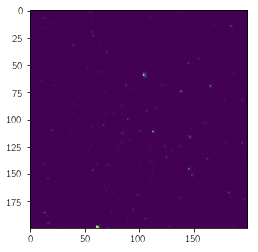

In [50]:
img = np.median(data, axis=0)
plt.imshow(img);

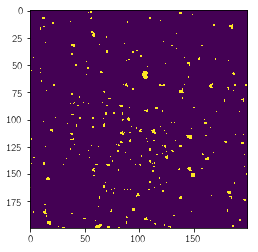

In [51]:
mu = np.median(img)
sigma = np.sqrt(np.median((img-mu)**2))
m = (img - mu) > 50*sigma

labels, nstar = label(m)

plt.imshow(m);

In [85]:
lcs = np.empty((nstar-1, len(data)), dtype=np.float32)
for star in range(nstar-1):
    lcs[star] = np.sum(data[:, labels == star+1], axis=1)
lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1

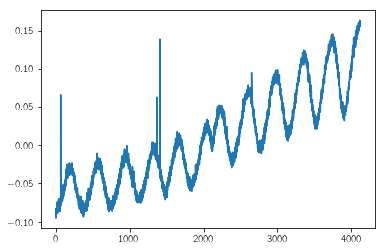

In [170]:
target = data[:, 174:178, 164:169]
target_lc = np.sum(target, axis=(1, 2))
target_lc = target_lc / np.median(target_lc) - 1
plt.plot(target_lc)

In [171]:
err = np.median(np.abs(np.diff(target_lc)))

In [197]:
T = tf.float32
np.random.seed(42)

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

y = tf.constant(target_lc, dtype=T)
X = tf.constant(lcs.T, dtype=T)

A0 = X.eval()
w0 = np.linalg.solve(np.dot(A0.T, A0), np.dot(A0.T, y.eval()))

lam = tf.constant(2, dtype=T)
w = tf.Variable(w0, dtype=T)

mod = tf.squeeze(tf.matmul(X, w[:, None]))
loss0 = tf.reduce_sum((y - mod)**2)
loss1 = lam * tf.reduce_sum(tf.abs(w))
loss = loss0 + loss1

opt = tf.train.AdamOptimizer(1e-2).minimize(loss)

session.run(tf.global_variables_initializer())

In [198]:
loss0.eval(), loss1.eval()

(0.8446663, 560.72925)

In [199]:
losses = np.empty(1000)
for i in range(len(losses)):
    session.run(opt)
    losses[i] = loss.eval()

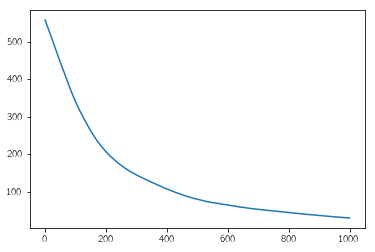

In [200]:
plt.plot(losses)

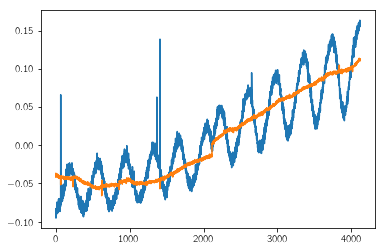

In [201]:
plt.plot(y.eval())
plt.plot(mod.eval())

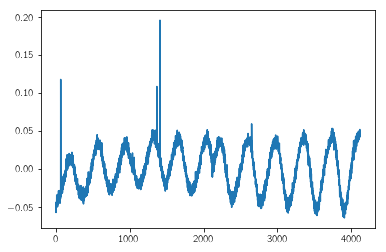

In [202]:
plt.plot(y.eval() - mod.eval())

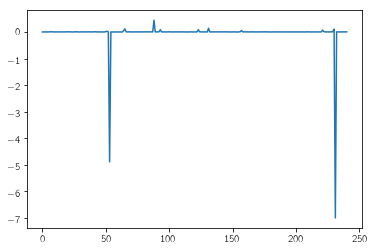

In [203]:
plt.plot(w.eval())